      fun: 441.9367574717252
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.69430318e+09, -7.53616488e+03])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 468
      nit: 10
   status: 2
  success: False
        x: array([1.19983359e-06, 2.23483751e-02])
country=India, beta=0.00000120, gamma=0.02234838, r_0:0.00005369


TypeError: ignored

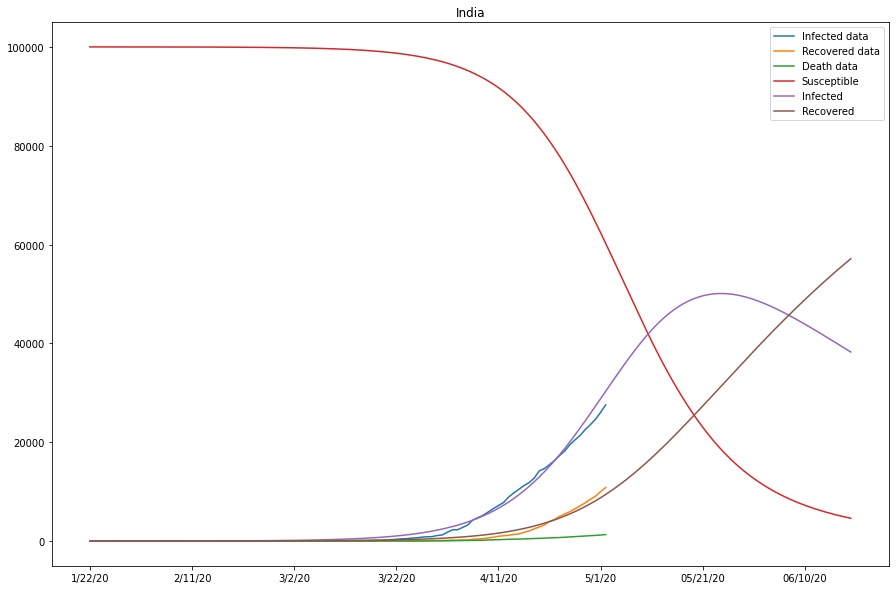

In [24]:
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime


confirmed_cases_file_link="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
death_cases_file_link="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
recovered_cases_file_link="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
country_cases_file_link= "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv"

START_DATE ={'India':'1/30/20'}
class Learner(object):
    def __init__(self, country, loss,start_date='1/22/20',predict_range=150,s_0=100000,i_0=2,r_0=10):
        self.country = country
        self.loss = loss
        self.start_date = start_date
        self.predict_range = predict_range
        self.s_0 = s_0
        self.i_0 = i_0
        self.r_0 = r_0


    def load_confirmed(self, country):
        df = pd.read_csv(confirmed_cases_file_link)
        df = df.drop(['Province/State'],axis=1)
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]


    def load_recovered(self, country):
        df = pd.read_csv(recovered_cases_file_link)
        df = df.drop(['Province/State'],axis=1)
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]


    def load_dead(self, country):
        df = pd.read_csv(death_cases_file_link)
        df = df.drop(['Province/State'],axis=1)
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]
    

    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

    def predict(self, beta, gamma, data, recovered, death, country, s_0, i_0, r_0):
        new_index = self.extend_index(data.index, self.predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
        extended_death = np.concatenate((death.values, [None] * (size - len(death.values))))
        return new_index, extended_actual, extended_recovered, extended_death, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))


    def train(self):
        recovered = self.load_recovered(self.country)
        death = self.load_dead(self.country)
        data = (self.load_confirmed(self.country) - recovered - death)
        
        optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, self.s_0, self.i_0, self.r_0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
        print(optimal)
        beta, gamma = optimal.x
        new_index, extended_actual, extended_recovered, extended_death, prediction = self.predict(beta, gamma, data, recovered, death, self.country, self.s_0, self.i_0, self.r_0)
        df = pd.DataFrame({'Infected data': extended_actual, 'Recovered data': extended_recovered, 'Death data': extended_death, 'Susceptible': prediction.y[0], 'Infected': prediction.y[1], 'Recovered': prediction.y[2]}, index=new_index)
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title(self.country)
        df.plot(ax=ax)
        print(f"country={self.country}, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
        fig.savefig(f"{self.country}.png")


def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

India_learner = Learner(country ="India",loss= loss,i_0=3)
India_sir , India_sir_fig = India_learner.train()









